In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.1
    Unin

In [3]:
# import libraries
import open3d as o3d
import numpy as np
import glob
import os
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow.keras.backend as K

In [4]:
# Load .ply Dataset
def read_ply_file(filepath):
    pcd = o3d.io.read_point_cloud(filepath)
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    return points, colors

def load_dataset(data_dir, num_points=1024):
    file_paths = glob.glob(os.path.join(data_dir, '**', '*.ply'), recursive=True)

    data, labels, file_paths_used = [], [], []
    label_map = {}

    for path in file_paths:
        points, colors = read_ply_file(path)
        if points.shape[0] == 0:
            continue

        pc_data = np.concatenate([points, colors], axis=1)
        pc_data = pc_data[:num_points]
        if pc_data.shape[0] < num_points:
            pad = np.zeros((num_points - pc_data.shape[0], 6))
            pc_data = np.vstack([pc_data, pad])

        label = os.path.basename(path).split('-')[0]
        if label not in label_map:
            label_map[label] = len(label_map)

        data.append(pc_data)
        labels.append(label_map[label])
        file_paths_used.append(path)

    return np.array(data), np.array(labels), label_map, file_paths_used

In [5]:
# Shuffle
def shuffle_data(data, labels):
    idx = np.arange(len(labels))
    np.random.shuffle(idx)
    return data[idx], labels[idx], idx

# Augmentation
def rotate_point_cloud(batch_data):
    rotated = np.zeros_like(batch_data)
    for i in range(batch_data.shape[0]):
        angle = np.random.uniform() * 2 * np.pi
        cosval, sinval = np.cos(angle), np.sin(angle)
        R = np.array([[cosval, 0, sinval], [0, 1, 0], [-sinval, 0, cosval]])
        rotated[i, :, :3] = np.dot(batch_data[i, :, :3], R.T)
        rotated[i, :, 3:] = batch_data[i, :, 3:]
    return rotated

def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    B, N, C = batch_data.shape
    noise = np.clip(sigma * np.random.randn(B, N, 3), -clip, clip)
    batch_data[:, :, :3] += noise
    return batch_data

In [6]:
#Point cloud visualization
def visualize_sample(sample, title=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    xyz = sample[:, :3]
    rgb = sample[:, 3:]

    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=rgb, s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        ax.set_title(title)
    plt.show()

In [7]:
# Load data
data_dir = '/content/drive/MyDrive/NoiseReductionChair'
data, labels, label_map, file_paths_used = load_dataset(data_dir)
print(f"Loaded {len(data)} samples with {len(label_map)} unique labels.")

# Data preprocessing
data, labels, _ = shuffle_data(data, labels)
data = rotate_point_cloud(data)
data = jitter_point_cloud(data)

Loaded 437 samples with 6 unique labels.


In [8]:
print (data.shape)
print(label_map)

(437, 1024, 6)
{'amia': 0, 'focusside': 1, 'hoopz': 2, 'torsa': 3, 'wittask': 4, 'X99': 5}


In [9]:
#index = random.randint(0, len(data)-1)
index = 0
label_name = list(label_map.keys())[list(label_map.values()).index(labels[index])]
print(f"Label index: {labels[index]}, Label name: {label_name}")

#visualize_sample(data[index], title=f"Label: {label_name}")

Label index: 1, Label name: focusside


In [10]:
#Plot distribution of samples
def plot_label_distribution(labels, label_map):
    index_to_label = {v: k for k, v in label_map.items()}
    label_counts = Counter(labels)
    names = [index_to_label[i] for i in sorted(label_counts.keys())]
    counts = [label_counts[i] for i in sorted(label_counts.keys())]
    plt.figure(figsize=(10, 5))
    plt.bar(names, counts, color='skyblue')
    plt.xlabel('Chair Model (Label Name)')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Chair Models in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

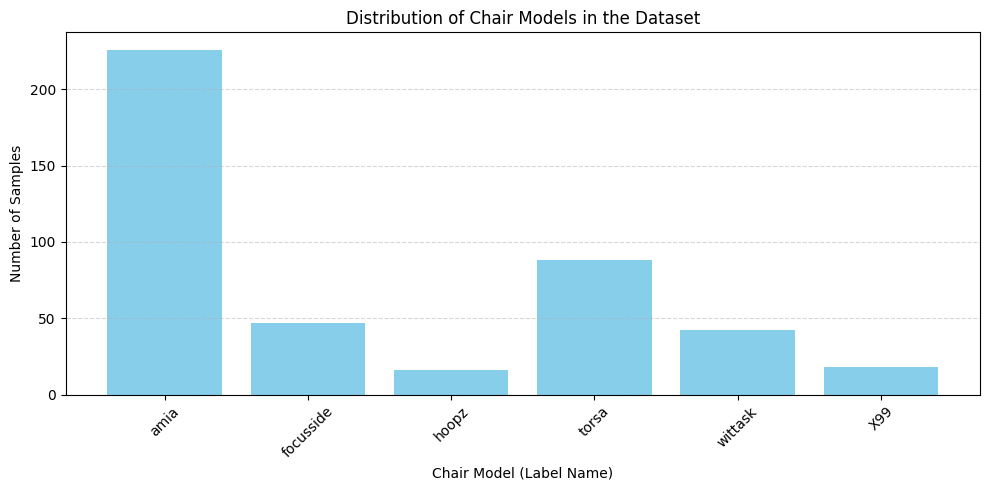

In [11]:
plot_label_distribution(labels, label_map)

In [12]:
#Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [13]:
# Orthogonality loss
class OrthogonalRegularizer(layers.Layer):
    def __init__(self, lam=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.lam = lam

    def call(self, matrix):
        k = tf.shape(matrix)[-1]
        eye = tf.eye(k)
        mat_t = tf.transpose(matrix, perm=[0, 2, 1])
        diff = tf.matmul(matrix, mat_t) - eye
        loss = self.lam * tf.reduce_mean(tf.square(diff))
        self.add_loss(loss)
        return matrix

In [14]:
# T-Net layers
def tnet(inputs, k):
    x = layers.Conv1D(64, 1, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(1024, 1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    eye = np.eye(k).flatten()
    bias_init = tf.keras.initializers.Constant(eye)
    x = layers.Dense(k * k, kernel_initializer="zeros",
                     bias_initializer=bias_init)(x)
    return layers.Reshape((k, k))(x)


class TransformLayer(layers.Layer):
    def __init__(self, k):
        super().__init__()
        self.k = k

    def call(self, inputs):
        feats, T = inputs
        return tf.matmul(feats, T)

In [15]:
# PointNet model architecture
def build_pointnet(num_points=1024,
                   input_channels=6,
                   num_classes=6,
                   lam=1e-3):

    inputs = tf.keras.Input(shape=(num_points, input_channels))
    xyz  = layers.Lambda(lambda t: t[:, :, :3])(inputs)
    aux  = layers.Lambda(lambda t: t[:, :, 3:])(inputs)

    # alignment
    T0   = tnet(xyz, k=3)
    T0   = OrthogonalRegularizer(lam)(T0)
    xyz  = TransformLayer(3)([xyz, T0])

    # shared MLP 1
    feats = layers.Concatenate()([xyz, aux])
    feats = layers.Conv1D(64, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(64, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)

    # feature alignment
    T1   = tnet(feats, k=64)
    T1   = OrthogonalRegularizer(lam)(T1)
    feats = TransformLayer(64)([feats, T1])

    # shared MLP 2
    feats = layers.Conv1D(64, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(128, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)
    feats = layers.Conv1D(1024, 1, activation="relu")(feats)
    feats = layers.BatchNormalization()(feats)

    # global feature & classifier
    x = layers.GlobalMaxPooling1D()(feats)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

In [16]:
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)
num_classes = y_train.shape[1]

model = build_pointnet(num_points=1024,
                       input_channels=6,
                       num_classes=num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(X_test, y_test),
          callbacks=[early_stop, reduce_lr],
          shuffle=True)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.2420 - loss: 2.6486 - val_accuracy: 0.3182 - val_loss: 2.8553 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.3336 - loss: 2.1369 - val_accuracy: 0.5568 - val_loss: 1.6208 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.4121 - loss: 1.7539 - val_accuracy: 0.5114 - val_loss: 1.6507 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4712 - loss: 1.8182 - val_accuracy: 0.5114 - val_loss: 1.4847 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4749 - loss: 1.8011 - val_accuracy: 0.5000 - val_loss: 1.4762 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.4227 - loss: 1.8038 - val_accuracy: 0.5114 - val_loss: 1.5359 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.4828 - loss: 1.6655 - val_accuracy: 

In [17]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - accuracy: 0.6946 - loss: 0.9479
Test Loss: 0.9713
Test Accuracy: 67.05%


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 918ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        46
           1       0.25      0.11      0.15         9
           2       0.67      0.67      0.67         3
           3       0.58      0.83      0.68        18
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         4

    accuracy                           0.67        88
   macro avg       0.37      0.42      0.39        88
weighted avg       0.56      0.67      0.60        88



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


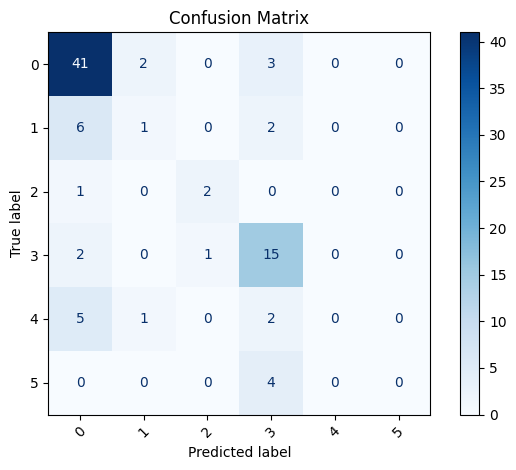

In [18]:
# Convert one-hot to labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [19]:
# Per-class perfoamnce
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, acc in enumerate(class_accuracy):
    class_name = [k for k, v in label_map.items() if v == idx][0]
    print(f"{class_name:>10}: {acc * 100:.2f}%")

      amia: 89.13%
 focusside: 11.11%
     hoopz: 66.67%
     torsa: 83.33%
   wittask: 0.00%
       X99: 0.00%


In [20]:
#test the trained model
for _ in range(3):
    i = np.random.randint(0, len(X_test))
    pred_label = [k for k, v in label_map.items() if v == y_pred[i]][0]
    true_label = [k for k, v in label_map.items() if v == y_true[i]][0]

    print(f"True: {true_label}, Predicted: {pred_label}")
    #visualize_sample(X_test[i], title=f"True: {true_label} | Predicted: {pred_label}")

True: torsa, Predicted: torsa
True: X99, Predicted: torsa
True: torsa, Predicted: torsa
